In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from statsmodels.tsa.stattools import ahistorical_datauller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.distributions.empirical_distribution import ECDF
pd.set_option('display.max_columns', None)

In [ ]:
historical_data = pd.read_csv('02 Sales_Expense_InputFile.csv')    # reading the input file

In [ ]:
account_potential = pd.read_csv('03 Account_Potential_Data.csv')
account_potential.columns  = account_potential.columns.str.capitalize()
account_potential['Account_id'] = account_potential['Account_id'].apply(lambda x: '{0:0>8}'.format(x))   ## Added leading zeros to account ids which were shorter than 8 in length
account_potential['Account_id'] = account_potential['Account_id'].astype(str)

In [ ]:
print ('Row Count: {}'.format(historical_data.shape[0]))                     #checking the file size
print ('Column Count: {}'.format(historical_data.shape[1]))

Row Count: 29541
Column Count: 10


In [ ]:
missing_values_columns = historical_data.isnull().sum().sort_values(ascending=False)    # checking for missing values (null is often interchangable with)
display(pd.DataFrame(missing_values_columns[missing_values_columns[missing_values_columns > 0].index]))

Empty DataFrame
Columns: [0]
Index: []

The data has no missing (null) values in any column.


In [ ]:
historical_data.dtypes    #checking data types of dataframe

ACCOUNT_ID                             int64
Type                                  object
COUNTRY                               object
PRODUCT                               object
MONTH                                 object
UNIT_SALES (in Million $)            float64
Per Unit Expense                     float64
TOTAL_EXPENSE (in Million $)         float64
SALESFORCE_EXPENSE (in Million $)    float64
DIGITAL_EXPENSE (in Million $)       float64
dtype: object

In [ ]:
#doing some initial formatting to the columns

# changing column names to lower case
historical_data.columns = historical_data.columns.str.capitalize()
## Added leading zeros to account ids which were shorter than 8 in length
historical_data['Account_id'] = historical_data['Account_id'].apply(lambda x: '{0:0>8}'.format(x))
# converting date column into datetime format
historical_data['Month'] = pd.to_datetime(historical_data['Month'])
# renaming the month column to week
historical_data.rename(columns = {'Month':'Week'}, inplace = True)
historical_data['Account_id'].astype(str)
# extracting year and month from date
historical_data['Year'] = historical_data['Week'].dt.year
historical_data['Month'] = historical_data['Week'].dt.month
display(historical_data.head(5))

Account_id    Type    Country Product       Week  Unit_sales (in million $)  \
0   00376321  Medium  COUNTRY 1  Drug_2 2010-08-01                  61.231684   
1   00376321  Medium  COUNTRY 1  Drug_2 2010-09-01                  47.286854   
2   00376321  Medium  COUNTRY 1  Drug_2 2010-10-01                  29.143185   
3   00376321  Medium  COUNTRY 1  Drug_2 2010-11-01                  74.909233   
4   00376321  Medium  COUNTRY 1  Drug_2 2010-12-01                  37.441141   

   Per unit expense  Total_expense (in million $)  \
0          5.827554                     10.507271   
1          4.277412                     11.055016   
2          1.919907                     15.179476   
3          5.073759                     14.764051   
4          2.455262                     15.249345   

   Salesforce_expense (in million $)  Digital_expense (in million $)  Year  \
0                           6.100165                        3.463933  2010   
1                           6.037500                        3.830352  2010   
2                           8.310196                        5.591070  2010   
3                           8.348021                        5.254492  2010   
4                           9.054047                        5.889636  2010   

   Month  
0      8  
1      9  
2     10  
3     11  
4     12

In [ ]:
print('No. of unique stores: ', historical_data['Account_id'].nunique())
if historical_data.groupby('Account_id')['Country'].nunique().sum() == 125:    # equal to unique accounts
  print('One account ID maps to one country')
if historical_data.groupby('Account_id')['Product'].nunique().sum() == 375:    # equal to unique accounts*3
  print('One account ID maps to three products')
#historicals_grouped =historical_data.groupby(by = ['Account_id', 'Product'])

No. of unique stores:  125
One account ID maps to one country
One account ID maps to three products


In [ ]:
#adding three required columns

historical_data['Salesforce_ratio'] = historical_data['Salesforce_expense (in million $)']/historical_data['Total_expense (in million $)']
historical_data['Profit'] = (historical_data['Unit_sales (in million $)'] - historical_data['Total_expense (in million $)'])
historical_data['Units number'] = historical_data['Total_expense (in million $)']/historical_data['Per unit expense']

In [ ]:
# taking the launch date of drug_3 for each account in a separate dataframe
account_list  = historical_data['Account_id'].unique()
df = pd.DataFrame()
df['Account_id']= account_list
for account in account_list:
  df.loc[df['Account_id']==account, 'Launch Date'] =  historical_data[(historical_data['Account_id']==account) & (historical_data['Product']=='Drug_3')]['Week'].sort_values(ascending =True).iloc[0]

df['Launch Date'] = pd.to_datetime(df['Launch Date']).dt.date
df['Launch Date'] = df['Launch Date'].astype(str)
df

Account_id Launch Date
0     00376321  2014-02-01
1     02097539  2015-02-01
2     00004613  2014-02-01
3     00541958  2014-03-01
4     00609418  2013-12-01
..         ...         ...
120   00558644  2014-03-01
121   00582457  2014-05-01
122   00343610  2014-11-01
123   00424763  2013-11-01
124   00006203  2013-12-01

[125 rows x 2 columns]

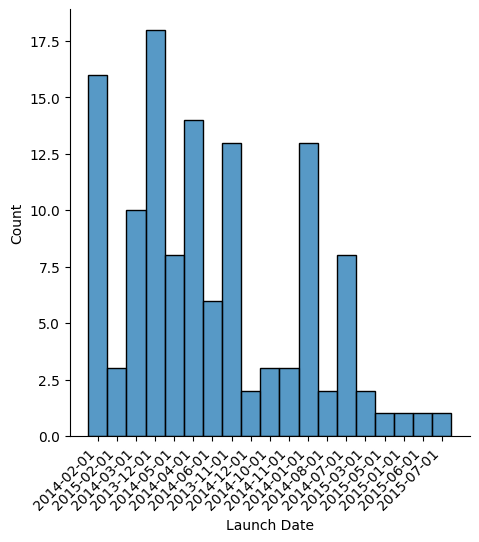

In [ ]:
# Since Drug-3 was launched at different dates in different stores, firstly analysing the launch dates for Drug-3
# Plotting the number of accounts where drug3 was launched on the specified date (accounts counts vs launch date)

ax = sns.displot(df['Launch Date'])
plt.xticks(
    rotation=45,
    horizontalalignment='right')

plt.show()

In [ ]:
df.rename(columns = {'Launch Date':'Week'}, inplace = True)
historical_data['Week'] = historical_data['Week'].astype(str)

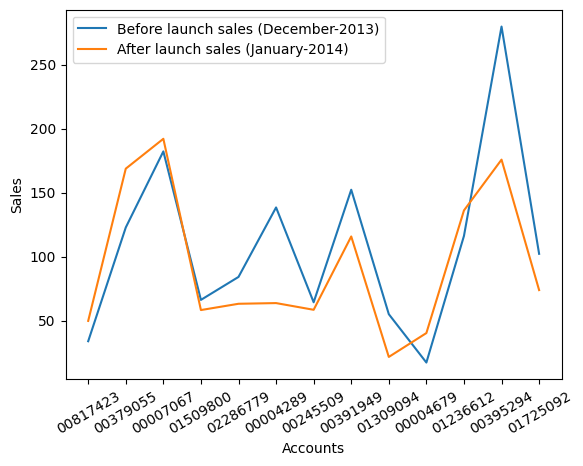

In [ ]:
# For the launch date of January 2014, a total of 10 accounts launched Drug_3
# Analysing the before and after launch sales of Drug_2, impacted by the launch of Drug_3


df1 = pd.merge(pd.merge(historical_data[['Account_id', 'Unit_sales (in million $)', 'Week', 'Product']], df[df['Week']== '2014-01-01'], on =['Account_id', 'Week'], how = 'inner'),
         pd.merge(historical_data[['Account_id', 'Type', 'Country','Unit_sales (in million $)', 'Week', 'Product']][historical_data['Week']=='2013-12-01'], df, on =['Account_id'], how = 'inner').rename(columns={'Unit_sales (in million $)':'Unit Sales Before'}),
         on =['Account_id', 'Product'], how = 'inner').drop(columns = {'Week', 'Week_x', 'Week_y'})

plt.plot(df1[df1['Product']=='Drug_2']['Account_id'],df1[df1['Product']=='Drug_2']['Unit Sales Before'], label = 'Before launch sales (December-2013)' )
plt.plot(df1[df1['Product']=='Drug_2']['Account_id'],df1[df1['Product']=='Drug_2']['Unit_sales (in million $)'] , label ='After launch sales (January-2014)')
plt.legend(loc="upper left")
plt.ylabel('Sales')
plt.xlabel('Accounts')
plt.xticks(rotation=30)
plt.show()

The above graph shows a comparision in the sales of Drug_2 in December 2013 vs January 2014. 8 out of the 12 stores took a hit in the sales of Drug_2 after the launch of Drug_3 in January 2014.

Text(0, 0.5, 'ECDF')

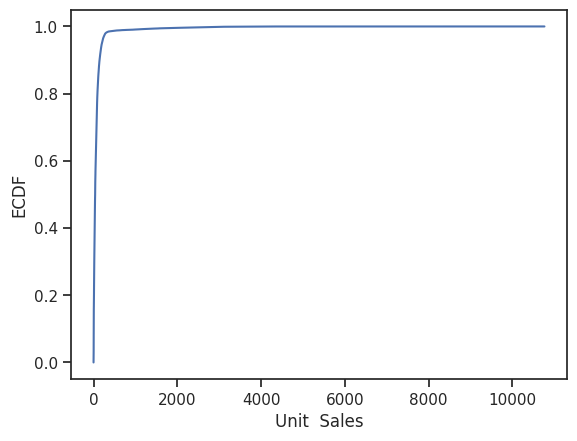

In [ ]:
#Plotting the Empirical Cumulative Distribution Graph of Sales


cdf = ECDF(historical_data['Unit_sales (in million $)'])
plt.plot(cdf.x, cdf.y, label = "statmodels")
plt.xlabel('Unit  Sales')
plt.ylabel('ECDF')

Although the highest monthly sales exceeded the massive figure of 10,000 million dollars, it is interesting to note that more than 90% of the data had monthly sales less than 1000 million dollars.

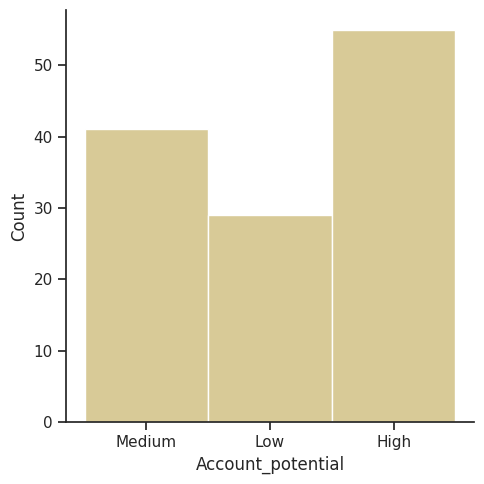

In [ ]:
# Analyzing the number of accounts grouped into High, Low and Medium respectively

ax = sns.displot(account_potential['Account_potential'], color = 'y')

There are 50+ high potential accounts and about 40 medium and 30 low potential ones.

**Analyzing Sales - On Different Levels**

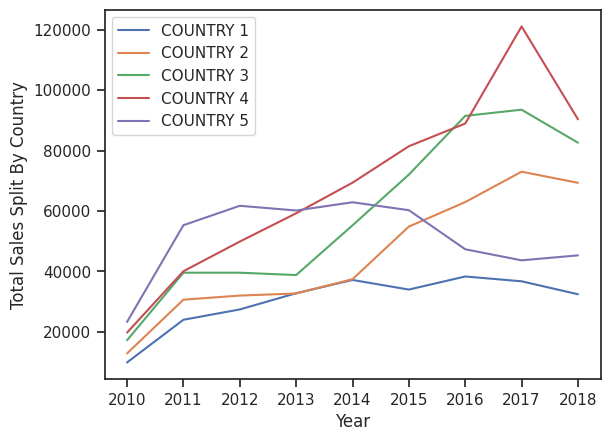

In [ ]:
#Country Level

df1 = historical_data.groupby(by = ['Country', 'Year']).agg({'Unit_sales (in million $)' : np.nansum, 'Total_expense (in million $)' : np.nansum}).reset_index()
for val in historical_data['Country'].unique():
  plt.plot(df1[df1['Country']==val]['Year'], df1[df1['Country']==val]['Unit_sales (in million $)'], label = val)
  plt.ylabel('Total Sales Split By Country')
  plt.xlabel('Year')
  plt.legend()

Countries 2,3 and 4 have had a somewhat steady increase in the drug sales, whereas Country 1 and 5 have experienced a decrease in its sales in the latter half of the decade.

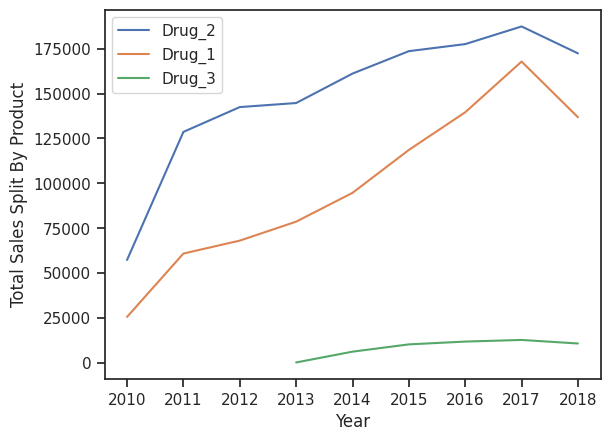

In [ ]:
#Product Level

df1 = historical_data.groupby(by = ['Product', 'Year']).agg({'Unit_sales (in million $)' : np.nansum, 'Total_expense (in million $)' : np.nansum}).reset_index()
for product_val in historical_data['Product'].unique():
  plt.plot(df1[df1['Product']==product_val]['Year'], df1[df1['Product']==product_val]['Unit_sales (in million $)'], label = product_val)
  plt.ylabel('Total Sales Split By Product')
  plt.xlabel('Year')
  plt.legend()

Majority of the sales have been recorded for Drug_2 followed by Drug_1. Drug_3 has recorded relatively lower levels of sales. An interesting point to note is the fact that Drug_2 has the highest recorded sales despite varied launch dates in different accounts.

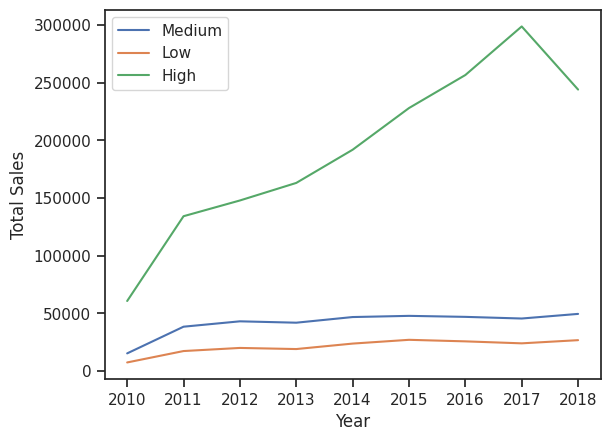

In [ ]:
# Account Potential Level

df1 = historical_data.groupby(by = ['Type', 'Year']).agg({'Unit_sales (in million $)' : np.nansum, 'Total_expense (in million $)' : np.nansum}).reset_index()
for type_val in historical_data['Type'].unique():
  plt.plot(df1[df1['Type']==type_val]['Year'], df1[df1['Type']==type_val]['Unit_sales (in million $)'], label = type_val)
  plt.ylabel('Total Sales')
  plt.xlabel('Year')
  plt.legend()

Intuitively, High potential accounts have recorded the maximum sales with a steady increase upto the year 2017. It has recorded a significant dip of around 16% in its total sales in the year 2018.

Medium and Low potential accounts have had a relativelty steady sale progess.

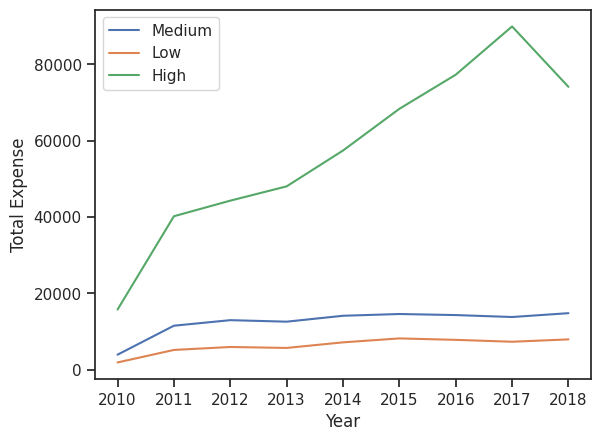

In [ ]:
#Analyzing the expense across different account potentials

df1 = historical_data.groupby(by = ['Type', 'Year']).agg({'Unit_sales (in million $)' : np.nansum, 'Total_expense (in million $)' : np.nansum}).reset_index()
for type_val in historical_data['Type'].unique():
  plt.plot(df1[df1['Type']==type_val]['Year'], df1[df1['Type']==type_val]['Total_expense (in million $)'], label = type_val)
  plt.ylabel('Total Expense')
  plt.xlabel('Year')
  plt.legend()

The cumulative expenses also recorded a somehwat similar trend as compared to the sales recorded. This hints a positive correlation between the total expenses and total sales recorded for different account potentials.

**Analyzing the Salesforce Ratio: the fraction of expenses spent in promotion through salesforce out of total expenses -**

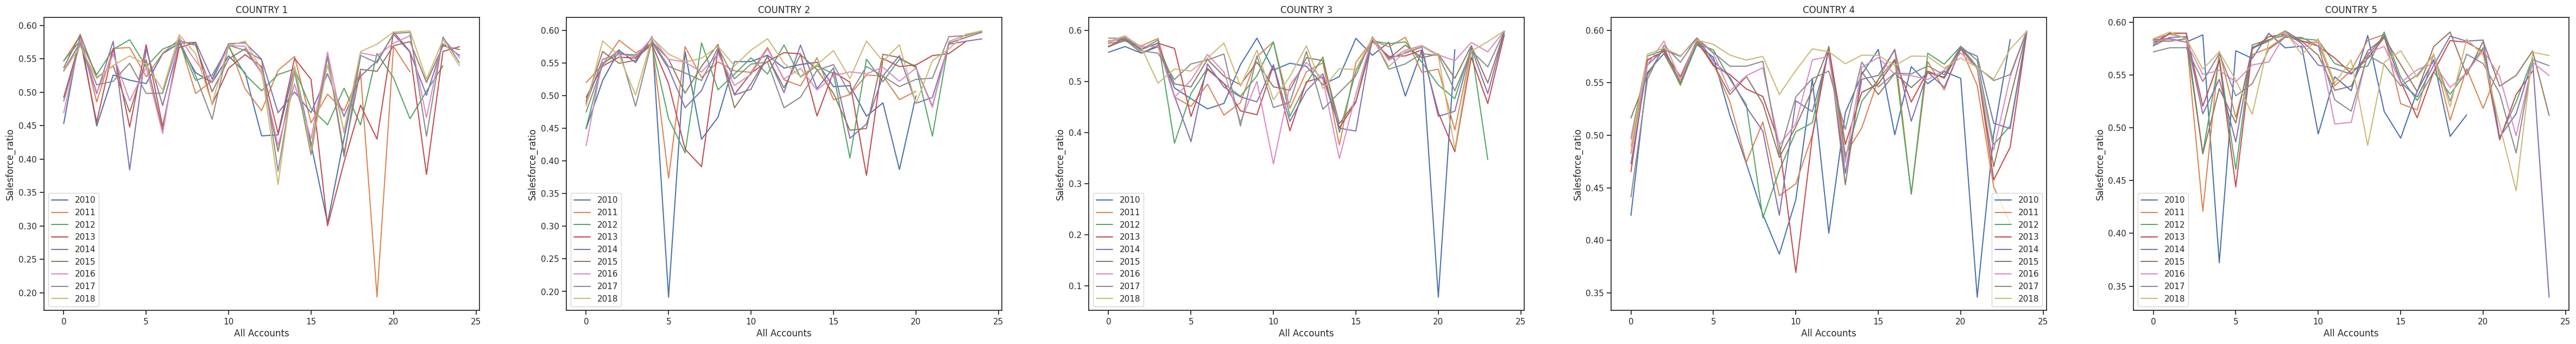

In [ ]:
# Analyzing the salesforces ratio for Drug_1 in 5 different countries
# The average salesforce ration recorded over the 12 months is taken for a comparative analysis


j=0;
fig, axes = plt.subplots(nrows=1, ncols=5, figsize =(60,7))
ax = axes.flatten()
for country in historical_data['Country'].unique():
  for year in historical_data['Year'].unique():
     ax[j].plot(historical_data[(historical_data['Country'] == country) & (historical_data['Year'] == year) & (historical_data['Product'] == 'Drug_1')].groupby(by = ['Account_id'])['Salesforce_ratio'].mean().reset_index()['Salesforce_ratio'], label = year)
     ax[j].legend()
  ax[j].set_title(country)
  ax[j].set_ylabel('Salesforce_ratio')
  ax[j].set_xlabel('All Accounts')
  j=j+1

**Analysis for Drug_1**:
For all the countries, the salesforce ratio has been majorly between 0.45 to 0.55, indicating a somewhat equal distribution of funds in on-ground and digital promotion. However, for Country-5 this ratio has been nearly around 0.6 for a significant part of the decade, indicating more on-ground promotional expenses.


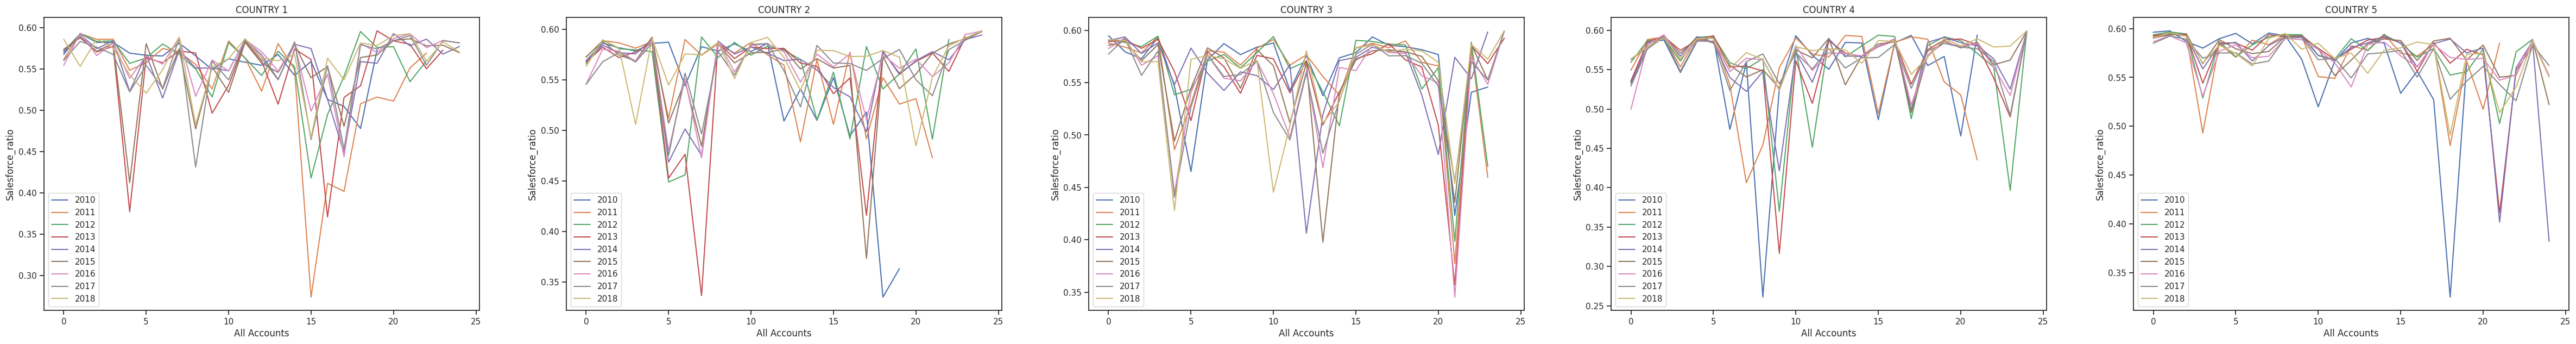

In [ ]:
#For Drug2 - in 5 countries separately for each year

j=0;
fig, axes = plt.subplots(nrows=1, ncols=5, figsize =(60,7))
ax = axes.flatten()
for country in historical_data['Country'].unique():
  for year in historical_data['Year'].unique():
     ax[j].plot(historical_data[(historical_data['Country'] == country) & (historical_data['Year'] == year) & (historical_data['Product'] == 'Drug_2')].groupby(by = ['Account_id'])['Salesforce_ratio'].mean().reset_index()['Salesforce_ratio'], label = year)
     ax[j].legend()
  ax[j].set_title(country)
  ax[j].set_ylabel('Salesforce_ratio')
  ax[j].set_xlabel('All Accounts')
  j=j+1

For Drug_2, we see this ratio majorly touching 0.6 for all the countries (except for some outliers). This points towards more on-ground promotional activities for Drug_2 in the five countries.

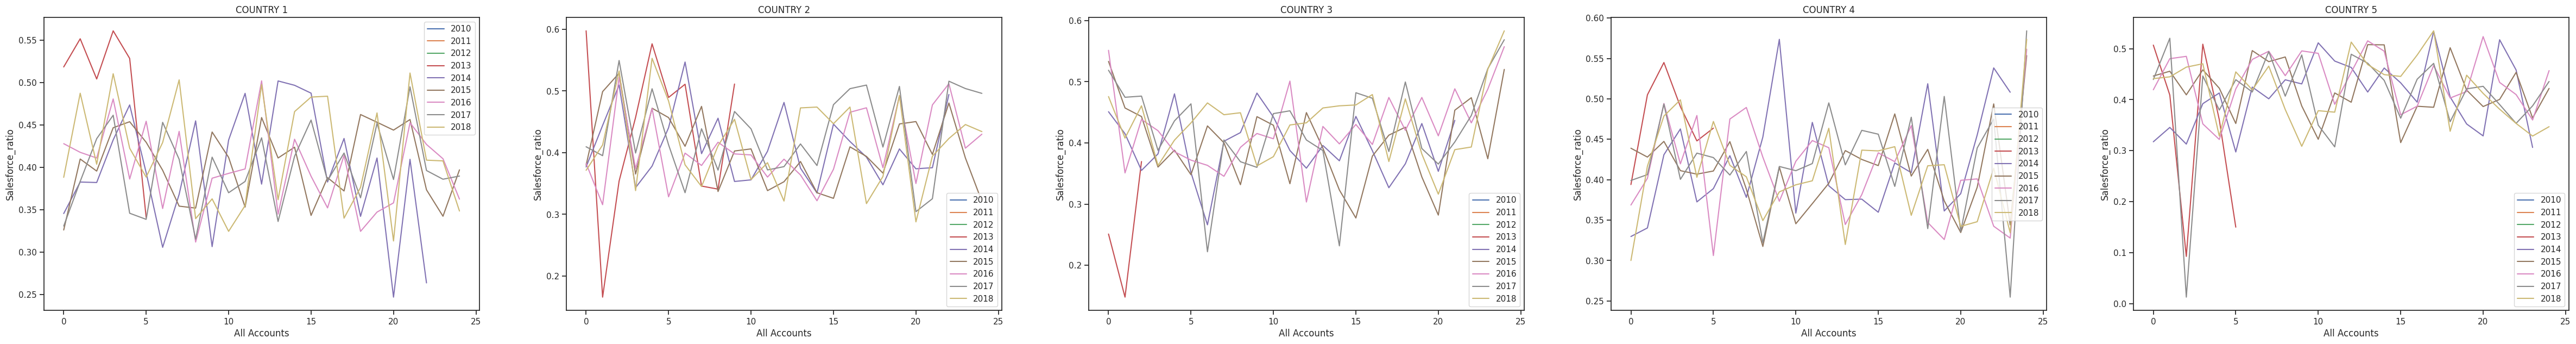

In [ ]:
#For Drug3 - in 5 countries separately for each year

j=0;
fig, axes = plt.subplots(nrows=1, ncols=5, figsize =(60,7))
ax = axes.flatten()
for country in historical_data['Country'].unique():
  for year in historical_data['Year'].unique():
     ax[j].plot(historical_data[(historical_data['Country'] == country) & (historical_data['Year'] == year) & (historical_data['Product'] == 'Drug_3')].groupby(by = ['Account_id'])['Salesforce_ratio'].mean().reset_index()['Salesforce_ratio'], label = year)
     ax[j].legend()
  ax[j].set_title(country)
  ax[j].set_ylabel('Salesforce_ratio')
  ax[j].set_xlabel('All Accounts')
  j=j+1

Interestingly, the salesforce expenses are a bit on the lower side for Drug_3. The mean value has been between 0.35 to 0.5, indicating higher digital expenses for Drug_3.

At this point, one should note that Drug_2 has recorded the maximum sales in different accounts whereas Drug_3 has recorded relatively skewed sales figures. This might indicate towards a postive coorelation between salesforce expenses and the total drug sales recorded.

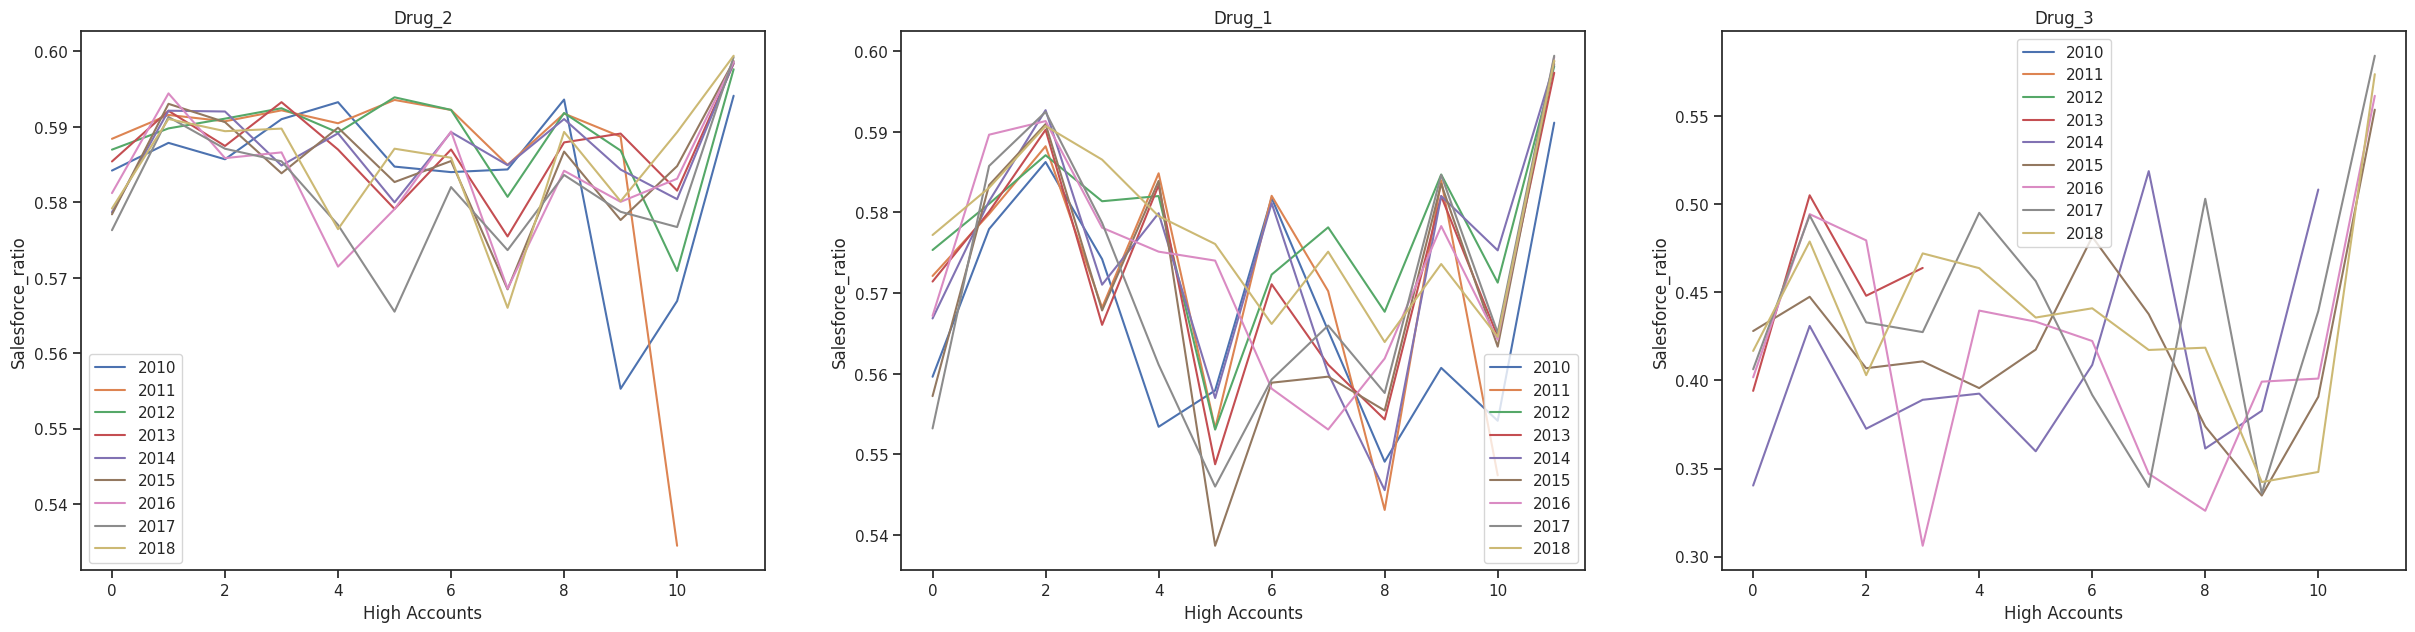

In [ ]:
#Country 4 - All Drugs - Analyzing the ratio pertinent to high potential accounts

j=0;
fig, axes = plt.subplots(nrows=1, ncols=3, figsize =(30,7))
ax = axes.flatten()
for drug in historical_data['Product'].unique():
    for year in historical_data['Year'].unique():
        ax[j].plot(historical_data[(historical_data['Country'] == 'COUNTRY 4') & (historical_data['Year'] == year) & (historical_data['Product'] == drug) & (historical_data['Type'] == 'High')].groupby(by = ['Account_id'])['Salesforce_ratio'].mean().reset_index()['Salesforce_ratio'], label = year)
        ax[j].legend()
    ax[j].set_title(drug)
    ax[j].set_ylabel('Salesforce_ratio')
    ax[j].set_xlabel('High Accounts')
    j=j+1

This trend is similar to what has been observed for all the accounts in the previous analysis.

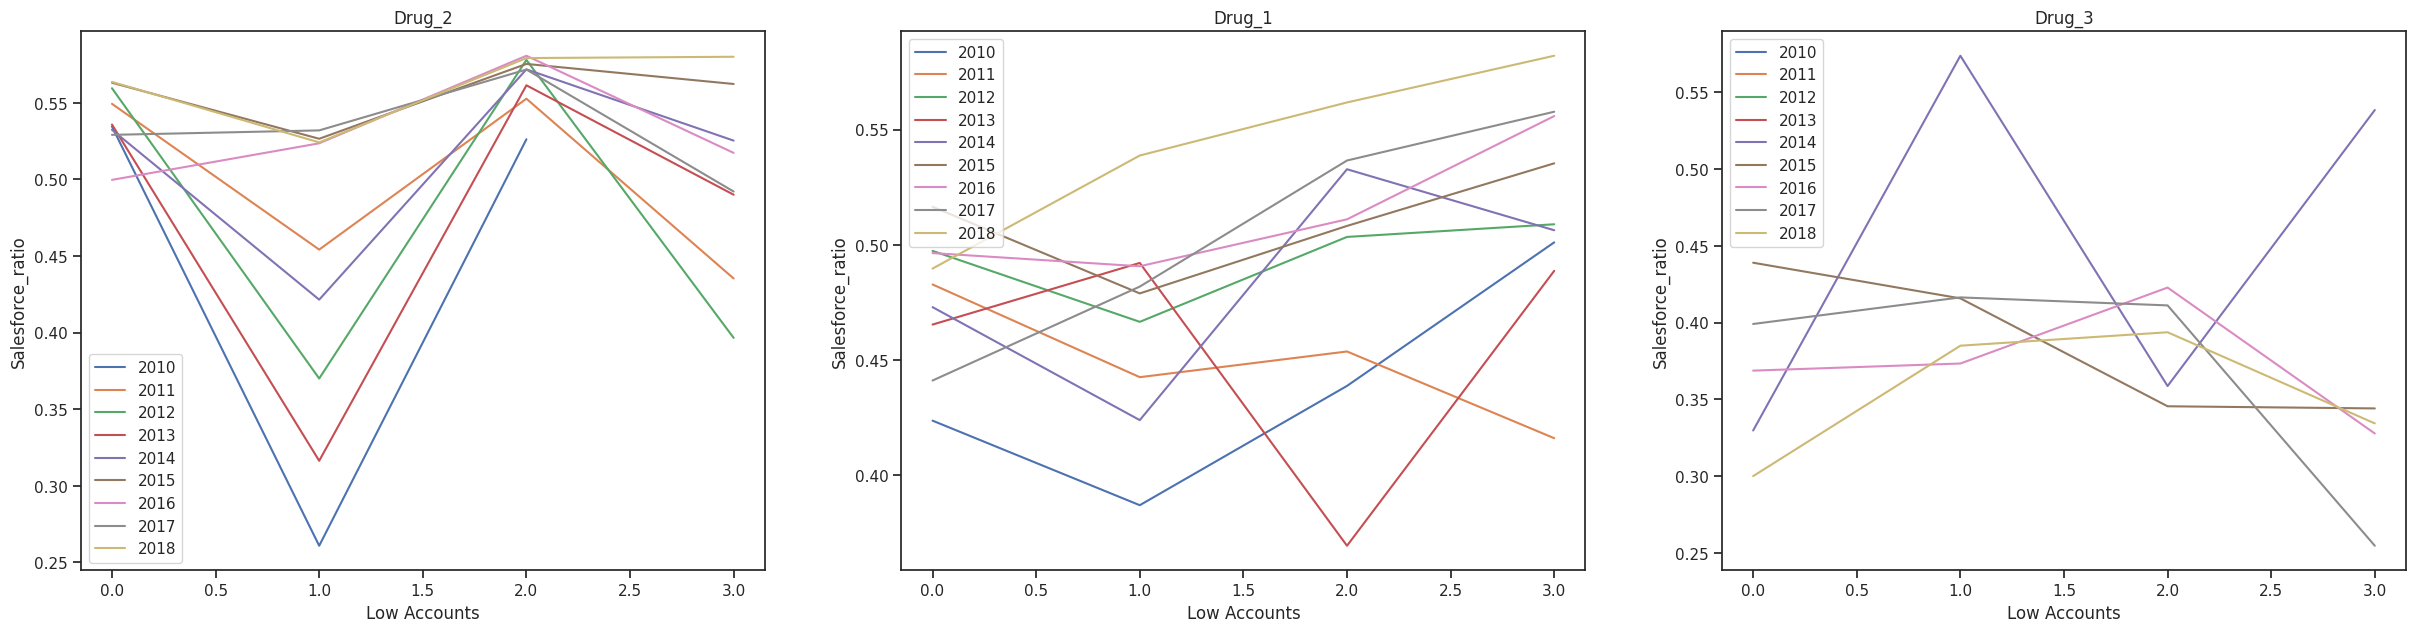

In [ ]:
#Country 4 - All Drugs - Analyzing the ratio pertinent to low potential accounts


j=0;
fig, axes = plt.subplots(nrows=1, ncols=3, figsize =(30,7))
ax = axes.flatten()
for drug in historical_data['Product'].unique():
    for year in historical_data['Year'].unique():
        ax[j].plot(historical_data[(historical_data['Country'] == 'COUNTRY 4') & (historical_data['Year'] == year) & (historical_data['Product'] == drug) & (historical_data['Type'] == 'Low')].groupby(by = ['Account_id'])['Salesforce_ratio'].mean().reset_index()['Salesforce_ratio'], label = year)
        ax[j].legend()
    ax[j].set_title(drug)
    ax[j].set_ylabel('Salesforce_ratio')
    ax[j].set_xlabel('Low Accounts')
    j=j+1

**Analyzing the historical Margin on different levels -**

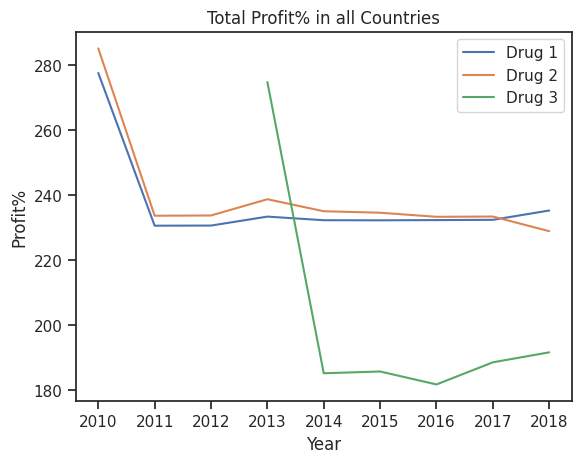

In [ ]:
#Overall profit split by products

df = historical_data.groupby(by = ['Product', 'Year']).agg({'Profit': np.sum, 'Total_expense (in million $)': np.sum}).reset_index()
df['Profit%'] = df['Profit']*100/df['Total_expense (in million $)']
drug1_data = df[df['Product'] == 'Drug_1']
drug2_data = df[df['Product'] == 'Drug_2']
drug3_data = df[df['Product'] == 'Drug_3']
plt.plot(drug1_data['Year'], drug1_data['Profit%'], label='Drug 1')
plt.plot(drug2_data['Year'], drug2_data['Profit%'], label='Drug 2')
plt.plot(drug3_data['Year'], drug3_data['Profit%'], label='Drug 3')
plt.title('Total Profit% in all Countries')
plt.ylabel('Profit%')
plt.xlabel('Year')
plt.legend()
plt.show()

Drug_1 and Drug_2 yield similar profits across all countries. However, there are high profits for Drug_3 during launch- which dips highly in the susequent years. Interestingly, Drug_1 and Drug_2 have not taken any significant hit in its Profit% after the release of Drug_3 in 2014.

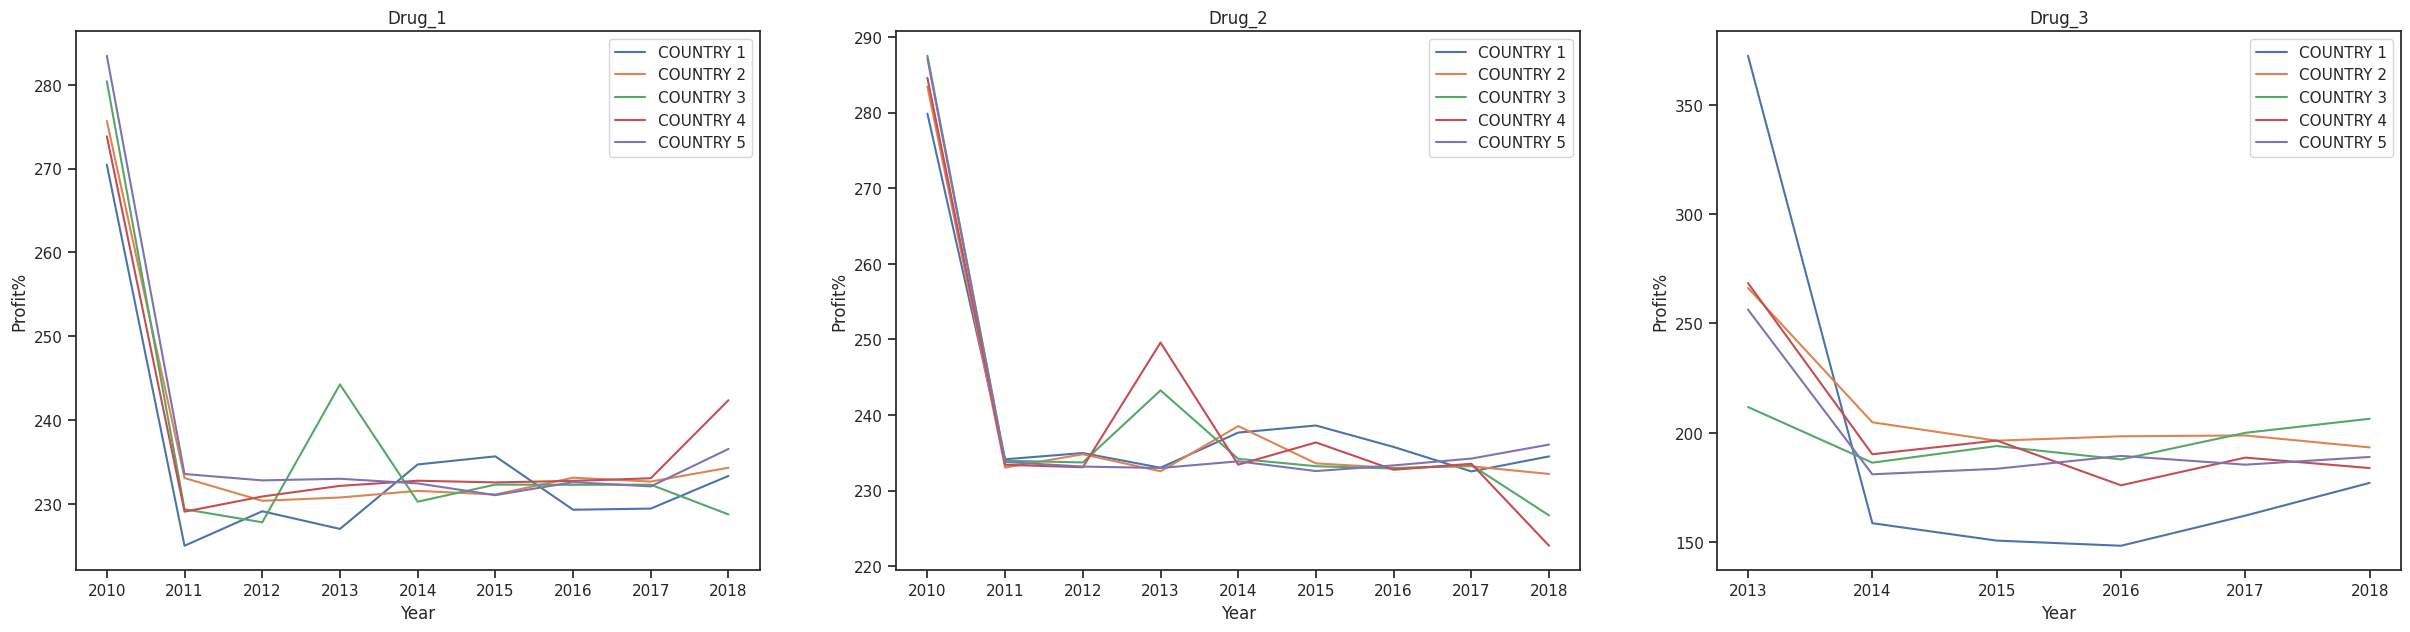

In [ ]:
#Overall profit made by products across the 5 countries in 8 years

df = historical_data.groupby(by = ['Product', 'Year','Country']).agg({'Profit': np.sum, 'Total_expense (in million $)': np.sum}).reset_index()
df['Profit%'] = df['Profit']*100/df['Total_expense (in million $)']


j=0;
fig, axes = plt.subplots(nrows=1, ncols=3, figsize =(30,7))
ax = axes.flatten()
for drug in df['Product'].unique():
    for country in df['Country'].unique():
        ax[j].plot(df[(df['Country'] == country)  & (df['Product'] == drug)]['Year'], df[(df['Country'] == country)  & (df['Product'] == drug)]['Profit%'], label = country)
        ax[j].legend()
    ax[j].set_title(drug)
    ax[j].set_ylabel('Profit%')
    ax[j].set_xlabel('Year')
    j=j+1

For Drug_1 and Drug_2, the total sales have become relatively steady after a sharp drop in 2011. For Drug_3, the same pattern is observed immediately after its release in 2014.

Text(0.5, 1.0, 'Total Profit Country 1  : D1+D2+D3')

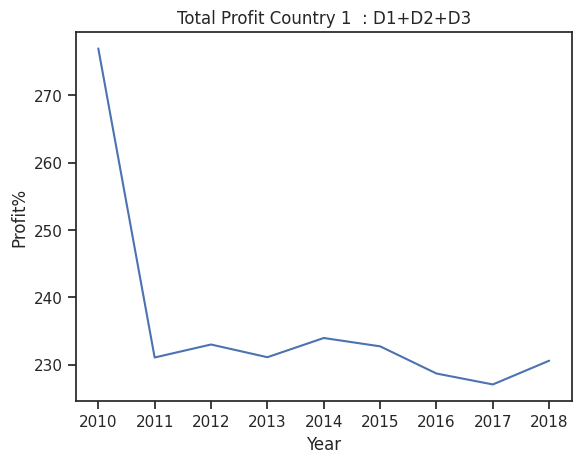

In [ ]:
# Total margin of all three Products combined in Country 1

df = historical_data.groupby(by = ['Year','Country']).agg({'Profit': np.sum, 'Total_expense (in million $)': np.sum}).reset_index()
df['Profit%'] = df['Profit']*100/df['Total_expense (in million $)']


df_totprofit = df[df['Country']=='COUNTRY 1'].groupby('Year').agg({'Profit': np.sum, 'Total_expense (in million $)': np.sum}).reset_index()
df_totprofit['Profit%'] = df_totprofit['Profit']*100/df_totprofit['Total_expense (in million $)']
plt.plot(df_totprofit['Year'],df_totprofit['Profit%'])
plt.ylabel('Profit%')
plt.xlabel('Year')
plt.title('Total Profit Country 1  : D1+D2+D3')


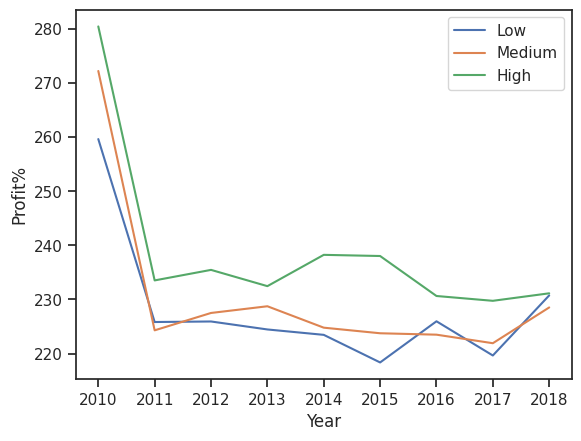

In [ ]:
#Digging deeper - the margin shared by individual account potentials in Country 1

df = historical_data.groupby(by = ['Year','Country', 'Type']).agg({'Profit': np.sum, 'Total_expense (in million $)': np.sum}).reset_index()
df_totprofit = df[df['Country']=='COUNTRY 1'].groupby(['Year', 'Type']).agg({'Profit': np.sum, 'Total_expense (in million $)': np.sum}).reset_index()
df_totprofit['Profit%'] = df_totprofit['Profit']*100/df_totprofit['Total_expense (in million $)']

type1_data = df_totprofit[df_totprofit['Type'] == 'Low']
type2_data = df_totprofit[df_totprofit['Type'] == 'Medium']
type3_data = df_totprofit[df_totprofit['Type'] == 'High']
plt.plot(type1_data['Year'], type1_data['Profit%'], label='Low')
plt.plot(type2_data['Year'], type2_data['Profit%'], label='Medium')
plt.plot(type3_data['Year'], type3_data['Profit%'], label='High')
plt.legend()
plt.ylabel('Profit%')
plt.xlabel('Year')
plt.show()

**Analyzing the margin made for each unit of a product across all countries every year -**


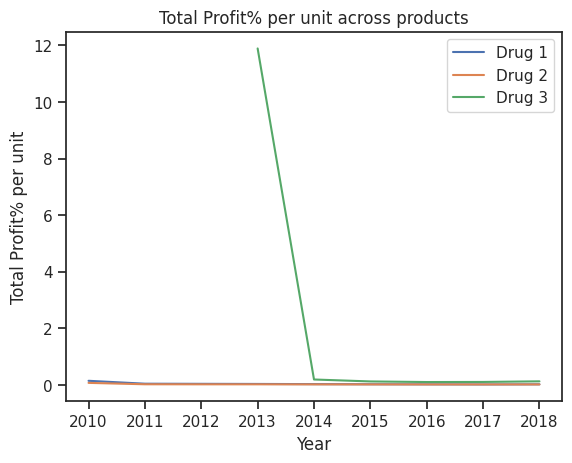

In [ ]:
df = historical_data.groupby(by = ['Product', 'Year']).agg({'Profit': np.sum, 'Units number': np.sum, 'Total_expense (in million $)': np.sum}).reset_index()
df['Profit% per unit'] = df['Profit']*100/(df['Total_expense (in million $)']*df['Units number'])
drug1_data = df[df['Product'] == 'Drug_1']
drug2_data = df[df['Product'] == 'Drug_2']
drug3_data = df[df['Product'] == 'Drug_3']
plt.plot(drug1_data['Year'], drug1_data['Profit% per unit'], label='Drug 1')
plt.plot(drug2_data['Year'], drug2_data['Profit% per unit'], label='Drug 2')
plt.plot(drug3_data['Year'], drug3_data['Profit% per unit'], label='Drug 3')
plt.title('Total Profit% per unit across products')
plt.ylabel('Total Profit% per unit')
plt.xlabel('Year')
plt.legend()
plt.show()

Drug 3 had high profit % during launch. Drug 1 and Drug 2 have profit between 0 to 1 % for each unit.

`**Checking the statistics of the data -**

In [ ]:
data_describe = historical_data.groupby(by =['Type'])['Unit_sales (in million $)'].describe().sort_values(by =['Type'], ascending =True).reset_index()
data_describe

Type    count        mean         std       min        25%        50%  \
0    High  13360.0  129.107299  326.646921  0.875579  25.534288  70.035889   
1     Low   6324.0   29.982477   33.272691  1.315953   7.874523  19.268580   
2  Medium   9857.0   37.940089   32.387712  1.713561  13.054368  30.811786   

          75%           max  
0  126.601688  10762.960580  
1   39.630568    283.504072  
2   53.570085    297.180388

The average sale numbers for High potential accounts are >100, ranging till 10k million dollars. The medium potential accounts have slightly higher sales, with average at 40 million dollars.  

In [ ]:
data_describe = historical_data.groupby(by =['Country'])['Unit_sales (in million $)'].describe().reset_index()
data_describe

Country   count        mean         std       min        25%        50%  \
0  COUNTRY 1  5824.0   46.825376   54.480880  1.185168  11.826904  29.857042   
1  COUNTRY 2  5886.0   68.932998  166.417999  0.875579  14.607579  34.462237   
2  COUNTRY 3  5883.0   90.096800  319.209263  1.518077  12.167631  32.762530   
3  COUNTRY 4  5990.0  103.516024  336.750974  1.755191  14.211351  42.084299   
4  COUNTRY 5  5958.0   77.191521   80.219844  1.857401  19.232811  53.587951   

          75%           max  
0   62.853962    734.111977  
1   73.198209   2746.961175  
2   74.322399   5623.444767  
3   84.104035  10762.960580  
4  107.530000    751.437886

Country 4 has the maximum average sales numbers, followed by Country 3 and Country 5.  

**Checking Seasonality in the Data (Here, for Country 1 and its stores for 8 years time period)**

In [ ]:
historical_data['Week'] = pd.to_datetime(historical_data['Week'])

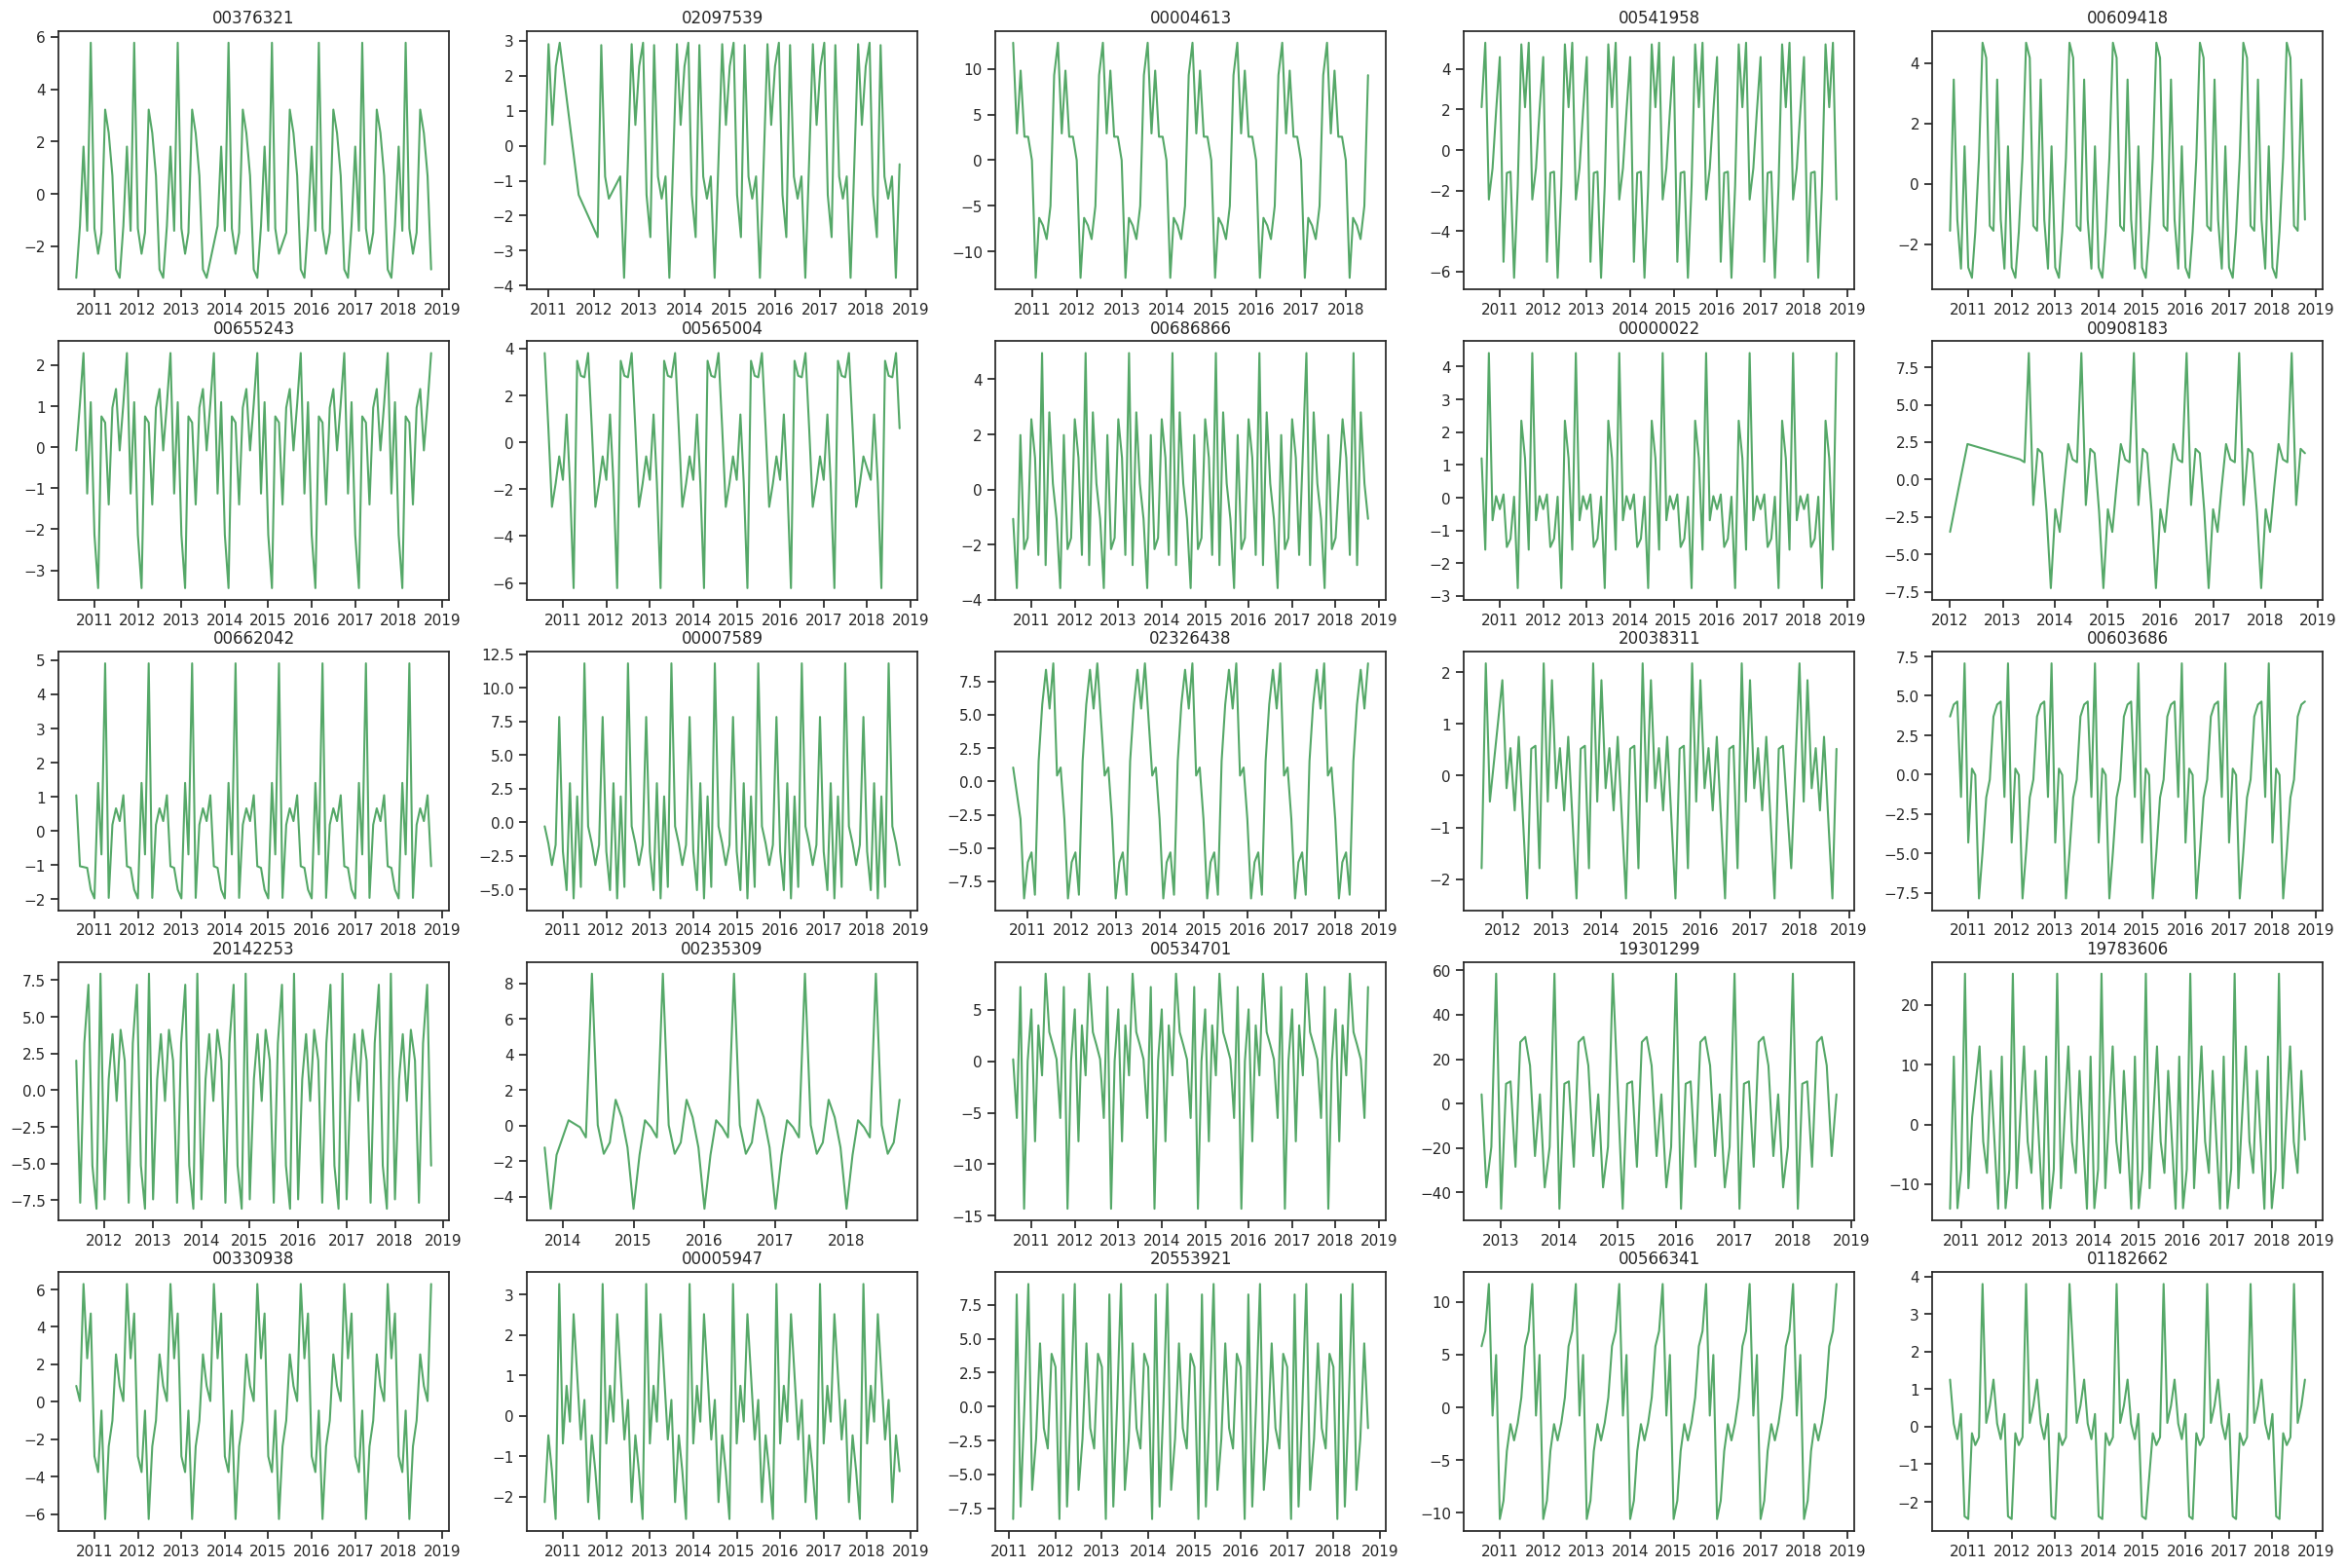

In [ ]:
sales_a = historical_data.query("Country =='COUNTRY 1' and Product =='Drug_1'")[['Account_id', 'Week' ,'Unit_sales (in million $)']].set_index('Week')

j=0;
fig, axes = plt.subplots(nrows=5, ncols=5, figsize =(30,20))
ax = axes.flatten()
unique_ac_list = sales_a['Account_id'].unique()
for ac in unique_ac_list:
  sales_ac  = sales_a[sales_a['Account_id']==ac].drop(columns = {'Account_id'})
  decomposition= seasonal_decompose(sales_ac, model = 'additive', period = 12)
  estimated_seasonal = decomposition.seasonal
  #ax[j].plot(estimated_seasonal, 'g', label='Seasonality')
  ax[j].plot(sales_ac)
  ax[j].set_title(ac)
  j=j+1

The data shows a seasinal trend for each store in country 1.  For some stores the sales numbers peak in the middle of the year and dip down forth towards the end.For some others, the year starts and ends with good sale.

In [ ]:
historical_data.columns

Index(['Account_id', 'Type', 'Country', 'Product', 'Week',
       'Unit_sales (in million $)', 'Per unit expense',
       'Total_expense (in million $)', 'Salesforce_expense (in million $)',
       'Digital_expense (in million $)', 'Year', 'Month', 'Salesforce_ratio',
       'Profit', 'Profit%', 'Units number'],
      dtype='object')

**Plotting the Correlation Heatmap**

<ipython-input-337-d6c0774ec654>:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



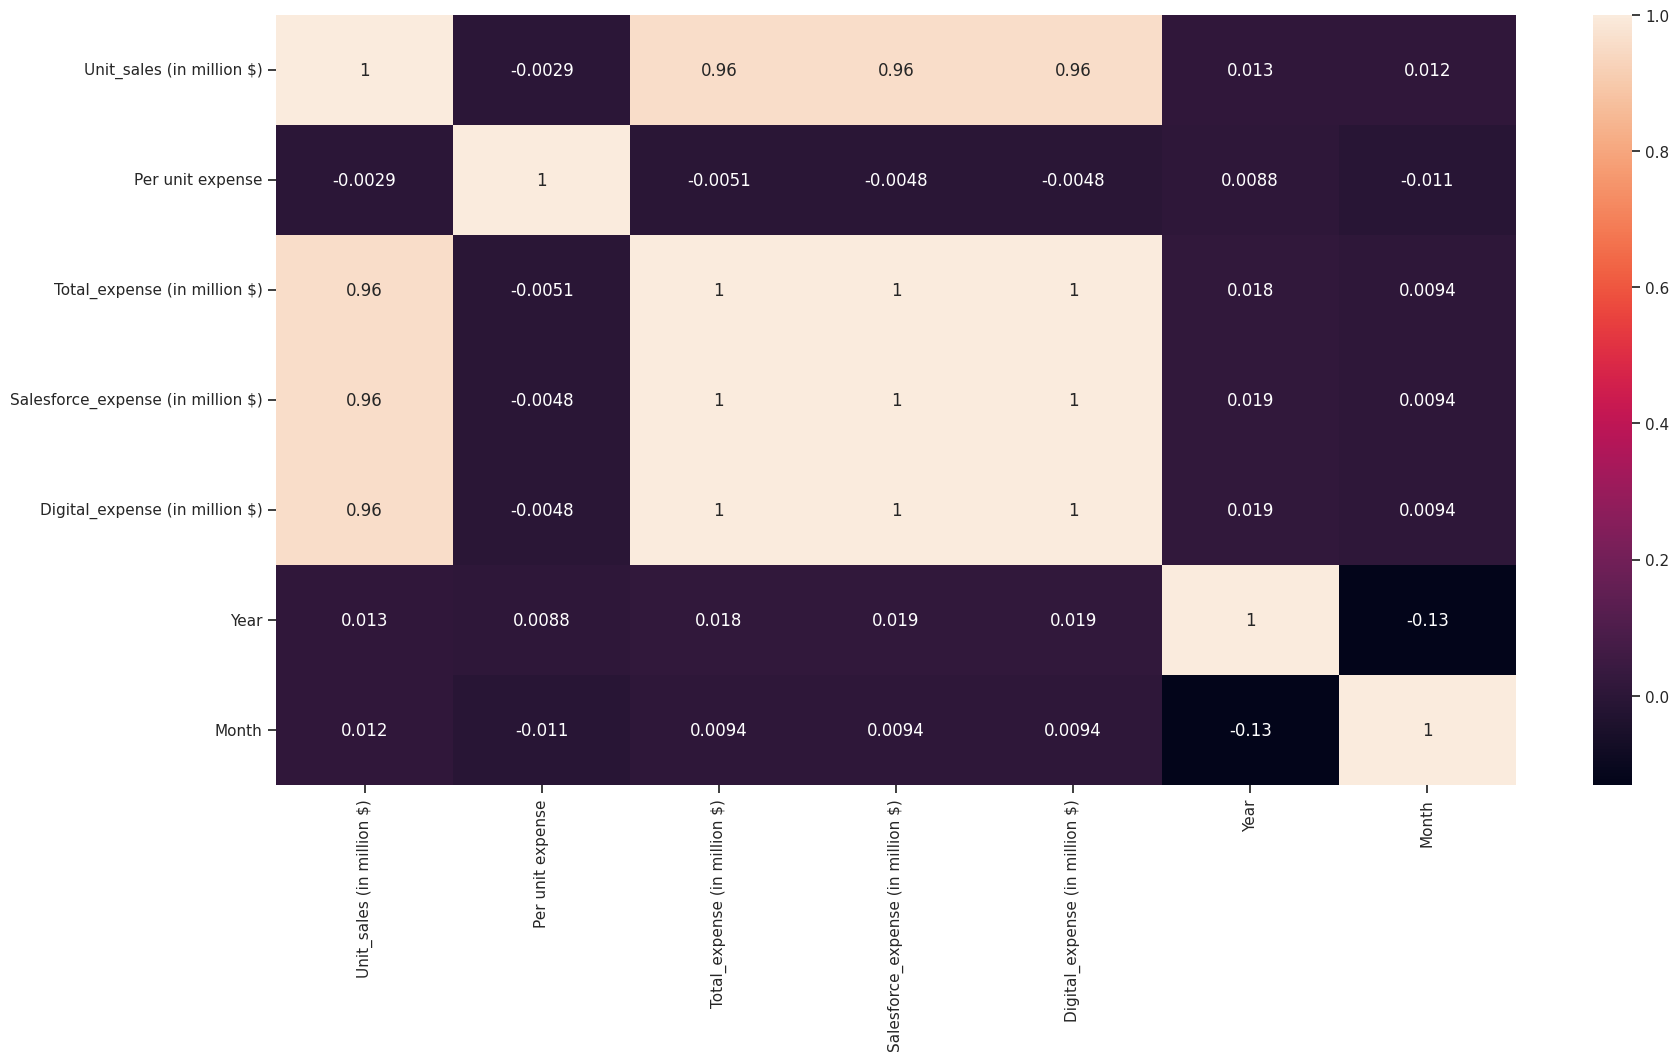

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(historical_data[['Account_id', 'Type', 'Country', 'Product', 'Week',
       'Unit_sales (in million $)', 'Per unit expense',
       'Total_expense (in million $)', 'Salesforce_expense (in million $)',
       'Digital_expense (in million $)', 'Year', 'Month']].corr(), annot = True)

As observed, there is a strong postive correlation between sales and the expenses. Time sequences have a slight positive effect on sales.